In [6]:
import matplotlib.pyplot as plt
import numpy as np

# tqdm是显示循环进度条的库
from tqdm import tqdm  



class CliffWalkingEnv:
    '''
    悬崖漫步环境
    不需要提供奖励函数和状态转移函数
    需要提供一个和智能体进行交互的函数 step
    '''
    
    def __init__(self, ncol, nrow):
        '''
        初始化
        ncol: 地图列数
        nrow: 地图行数
        '''
        
        # 设置行列
        self.nrow = nrow
        self.ncol = ncol
        
        # 初始化智能体位置的横纵坐标，在左下角
        self.x = 0  
        self.y = self.nrow - 1 

    def step(self, action):  
        '''
        外部调用这个函数来改变当前位置
        '''
        
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。
        # 坐标系原点(0,0) 在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        
        # 更新位置，保持在地图内
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        
        # 获取下一状态
        next_state = self.y * self.ncol + self.x
        
        # 获取进入下一状态的奖励
        reward = -1
        done = False
        
        # 检查下一个位置在悬崖或者目标
        if self.y == self.nrow - 1 and self.x > 0:  
            # 结束
            done = True
            
            # 如果在悬崖，奖励 -100
            if self.x != self.ncol - 1:
                reward = -100
        
        # 返回 下一个状态，奖励，结束标识
        return next_state, reward, done

    def reset(self): 
        '''
        重置
        回归初始状态,坐标轴原点在左上角
        初始化位置在左下角
        '''
        
        # 初始化位置在左下角
        self.x = 0
        self.y = self.nrow - 1
        
        return self.y * self.ncol + self.x

In [7]:
class Sarsa:
    """ 
    Sarsa算法 
    行为策略与目标策略均为 e-greedy
    通过TD算法更新状态动作价值表
    """
    
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        '''
        ncol: 地图横坐标
        nrow: 地图纵坐标
        epsilon: e-greedy 算法参数
        alpha: 学习率
        gamma: 回报折扣因子
        n_action=4: 动作个数
        '''
        
        # 初始化Q(s,a)表格
        # s_num = nrow*ncol
        # Q(s, a).size = s_num * n_action
        self.Q_table = np.zeros([nrow * ncol, n_action])  
        
        # 动作个数
        self.n_action = n_action  
        
        # 学习率
        self.alpha = alpha  
        
        # 折扣因子
        self.gamma = gamma  
        
        # epsilon-贪婪策略中的参数
        self.epsilon = epsilon  

    def take_action(self, state):
        '''
        选取下一步的操作, 具体实现为e-greedy策略
        '''
        
        # < e, 随机选一个策略
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        
        # > e, 选择Q(s, a)中当前状态下价值最大的动作索引
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  
        '''
        用于打印最佳动作策略
        state: 当前状态s
        '''
        
        # 当前状态下最大的动作价值
        Q_max = np.max(self.Q_table[state])
        
        # 初始化最佳动作策略 [0, 0, 0, 0]
        a = [0 for _ in range(self.n_action)]
        
        # 最大动作价值的动作，被记录为1
        # 若两个动作的价值一样,都会记录下来
        for i in range(self.n_action):  
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
                
        # 假如第一个动作与第三个动作都有最大动作价值
        # a = [1, 0, 1, 0]
        return a

    def update(self, s0, a0, r, s1, a1):
        '''
        更新状态动作价值表
        s0, a0, r: 当前的状态，动作，奖励
        s1, a1: 下一步状态，动作
        '''
        
        # TD误差，(r + gamma * Q(s1, a1)) - Q(s0, a0)
        # 该误差，说明当前的状态动作价值Q(s0, a0)相比与当前的奖励部分存在误差
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        
        # 将TD误差乘以学习率，用来更新当前的状态动作价值Q(s0, a0)
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|████████████████████| 50/50 [00:00<00:00, 4089.93it/s, episode=500, return=-18.900]


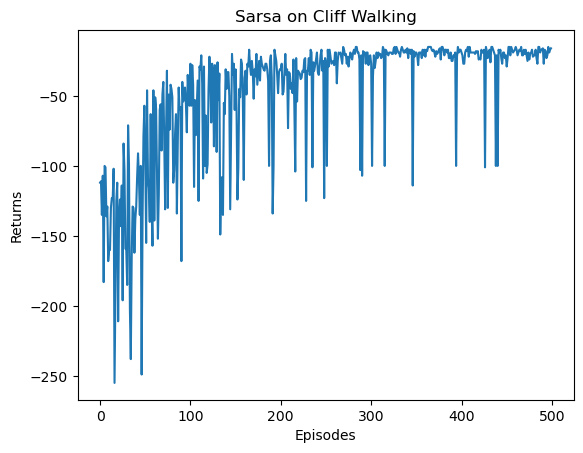

In [8]:
# 初始化悬崖漫步环境
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0) # 随机数
epsilon = 0.1 # e-greedy 参数
alpha = 0.1 # 学习率 状态动作价值表的学习率
gamma = 0.9 # 回报折扣因子

# 初始化sarsa智能体
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)

# 智能体在环境中运行的序列的数量
num_episodes = 500  

# 记录每一条序列的回报
return_list = []  

# 显示10个进度条
for i in range(10):  
    
    # tqdm的进度条功能，每个进度条的序列数量是 总数/10
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        
         # 每个进度条的序列数
        for i_episode in range(int(num_episodes / 10)): 
            
            # 初始化当前序列的总回报
            episode_return = 0
            
            # 初始化环境
            state = env.reset()
            
            # 选择一个动作（e-greedy）
            action = agent.take_action(state)
            done = False
            
            # 开始智能体的动作迭代，生成序列
            while not done:
                # 执行动作
                # 获取 下一状态，奖励，结束标识
                next_state, reward, done = env.step(action)
                
                # 累计回报
                # 这里回报的计算不进行折扣因子衰减
                episode_return += reward 
                
                # 根据下一状态选择下一个动作
                next_action = agent.take_action(next_state)
                
                # 根据当前状态-动作-奖励 以及 下一状态-下一动作 更新状态动作价值表
                agent.update(state, action, reward, next_state, next_action)
                
                # 更新状态与动作
                state = next_state
                action = next_action
                
            # 当前序列总回报
            return_list.append(episode_return)
            
            # 每10条序列打印一下这10条序列的平均回报
            if (i_episode + 1) % 10 == 0:  
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# 显示序列总奖励的训练结果
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

# 随着训练的进行，Sarsa 算法获得的回报越来越高
# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1206.19it/s, episode=50,
# return=-119.400]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1379.84it/s, episode=100,
# return=-63.000]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2225.14it/s, episode=150,
# return=-51.200]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2786.80it/s, episode=200,
# return=-48.100]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 1705.21it/s, episode=250,
# return=-35.700]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3393.12it/s, episode=300,
# return=-29.900]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 3694.32it/s, episode=350,
# return=-28.300]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 3705.87it/s, episode=400,
# return=-27.700]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4115.61it/s, episode=450,
# return=-28.500]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3423.20it/s, episode=500,
# return=-18.900]

In [9]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    """
    打印动作策略
    agent: 智能体
    env: 环境
    action_meaning: 动作符号
    disaster=[]: 坑洞
    end=[]: 目标
    """
    
    # 遍历地图
    for i in range(env.nrow):
        for j in range(env.ncol):
            # 打印坑洞与边缘位置
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
                
            # 打印目标位置
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
                
            # 打印其他位置的动作
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


# 动作符号
action_meaning = ['^', 'v', '<', '>']

# 打印地图与对应的动作
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


Iteration 9: 100%|████████████████████| 50/50 [00:00<00:00, 5208.25it/s, episode=500, return=-19.100]


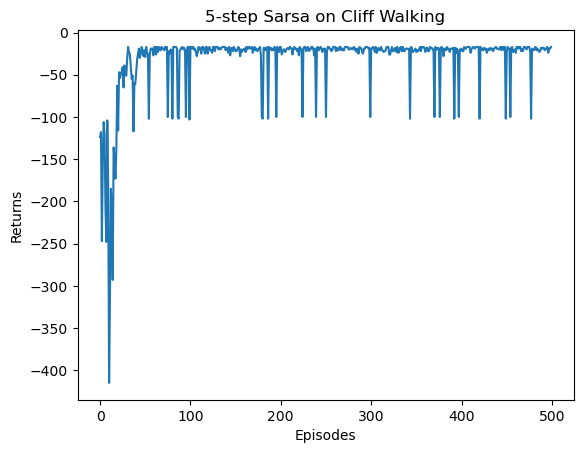

In [10]:
class nstep_Sarsa:
    """ 
    n步Sarsa算法 
    行为策略与目标策略均为 e-greedy
    通过多步TD算法更新状态动作价值表
    """
    
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        """
        n: n步Sarsa
        ncol: 地图横坐标
        nrow: 地图纵坐标 
        epsilon: e-greedy 参数
        alpha: 学习率
        gamma: 折扣因子
        n_action=4: 动作数量
        """
        
        # Q(s, a) 状态动作价值表
        self.Q_table = np.zeros([nrow * ncol, n_action])
        
        # 参数初始化
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  
        
        # 历史记录
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def take_action(self, state):
        """
        执行动作，采用 e-greedy 策略
        state: 当前状态
        """
        
        # <e, 随机采样动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
            
        # >=e, 采用价值最大的动作
        else:
            action = np.argmax(self.Q_table[state])
            
        return action

    def best_action(self, state):
        """
        最佳动作， 
        用于打印策略
        [0, 1, 0, 1] 表示第二个与第四个动作为最佳动作
        """
        
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        """
        更新状态价值表
        s0, a0, r：当前状态，当前动作，奖励
        s1, a1：下一次状态，下一次动作
        done：结束标识
        """
        
        # s0, a0, r 加入历史记录
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        
        # 若保存的历史数据可以进行n步更新，即已保存了n个历史数据
        if len(self.state_list) == self.n:  
            # 得到Q(s_{t+n}, a_{t+n})
            G = self.Q_table[s1, a1]  
            
            # 从后往前计算历史折扣回报
            for i in reversed(range(self.n)):
                # 考虑折扣因子
                G = self.gamma * G + self.reward_list[i]
                
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                # 相当于更新1步到n-1步
                if done and i > 0:
                    # 倒序获取s,a
                    s = self.state_list[i]
                    a = self.action_list[i]
                    
                    # 单步更新状态动作价值表
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
                    
            # 将需要更新的状态动作从列表中删除,下次不必更新
            # 删除最开始一帧
            s = self.state_list.pop(0)  
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            
        # 如果到达终止状态,即将开始下一条序列,则将列表全清空
        if done:  
            self.state_list = []
            self.action_list = []
            self.reward_list = []


# 设置随机种子
np.random.seed(0)

# 5步Sarsa算法
n_step = 5  
alpha = 0.1
epsilon = 0.1
gamma = 0.9
num_episodes = 500  # 智能体在环境中运行的序列的数量
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)

# 记录每一条序列的回报
return_list = []  

# 显示10个进度条
for i in range(10):  
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        # 每个进度条的序列数
        for i_episode in range(int(num_episodes / 10)):  
            # 初始化序列总回报
            episode_return = 0
            
            # 初始化环境，获取初始状态动作
            state = env.reset()
            action = agent.take_action(state)
            
            # 开始序列
            done = False
            while not done:
                #  获取下一状态，回报，结束标识
                next_state, reward, done = env.step(action)
                
                # 获取下一动作
                next_action = agent.take_action(next_state)
                
                # 序列总回报
                # 这里回报的计算不进行折扣因子衰减
                episode_return += reward  
                
                # 更新状态动作价值表
                agent.update(state, action, reward, next_state, next_action, done)
                
                # 更新状态与动作
                state = next_state
                action = next_action
                
            # 记录序列总回报
            return_list.append(episode_return)
            
            # 每10条序列打印一下这10条序列的平均回报
            if (i_episode + 1) % 10 == 0:  
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# 可视化序列总回报的训练流程
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

# 5 步 Sarsa 算法的收敛速度比单步 Sarsa 算法更快
# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 937.03it/s, episode=50,
# return=-26.500]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 2955.94it/s, episode=100,
# return=-35.200]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2978.95it/s, episode=150,
# return=-20.100]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 3062.61it/s, episode=200,
# return=-27.200]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3172.36it/s, episode=250,
# return=-19.300]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3123.41it/s, episode=300,
# return=-27.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2875.33it/s, episode=350,
# return=-28.000]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 2262.18it/s, episode=400,
# return=-36.500]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 3100.00it/s, episode=450,
# return=-27.000]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3107.54it/s, episode=500,
# return=-19.100]

In [11]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# 此时多步 Sarsa 算法得到的策略会在最远离悬崖的一边行走，以保证最大的安全性
# 5步Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo
# ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


Iteration 9: 100%|████████████████████| 50/50 [00:00<00:00, 5667.98it/s, episode=500, return=-61.700]


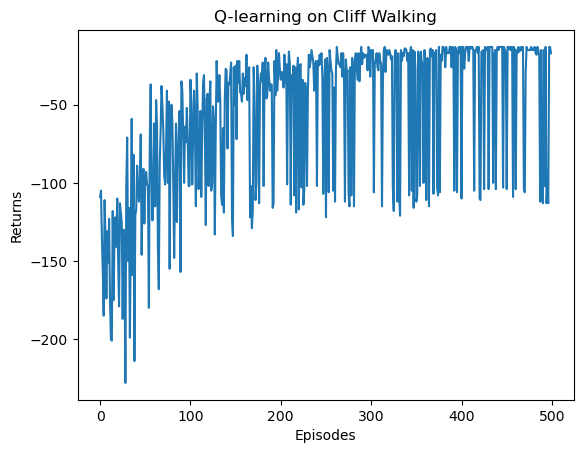

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [12]:
class QLearning:
    """ 
    Q-learning算法 
    行为策略采用 e-greedy
    目标策略采用 max
    异策略，离线策略
    """
    
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        """
        初始化
        ncol：地图横坐标
        nrow：地图纵坐标
        epsilon：e-greedy 参数
        alpha：学习率
        gamma：折扣因子
        n_action=4：动作数量
        """
        # 初始化Q(s,a)表格
        self.Q_table = np.zeros([nrow * ncol, n_action])
        
        # 初始化参数
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  
        """
        选取下一步动作
        行为策略：e-greedy 算法
        state: 当前状态
        """
        
        # <e, 随机选择一个动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
            
        # >e，选择最大动作价值的动作
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  
        """
        最佳动作， 
        用于打印策略
        [0, 1, 0, 1] 表示第二个与第四个动作为最佳动作
        """
        
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        """
        更新状态动作价值表
        目标策略：通过 max 选取动作
        四元组 s0, a0, r, s1
        """
        
        # 计算单步TD误差
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        
        # 更新状态动作价值表
        self.Q_table[s0, a0] += self.alpha * td_error


# 初始化智能体
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
num_episodes = 500  # 智能体在环境中运行的序列的数量
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)

# 记录每一条序列的回报
return_list = []  

# 显示10个进度条
for i in range(10): 
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        # 每个进度条的序列数
        for i_episode in range(int(num_episodes / 10)):  
            # 初始化序列
            episode_return = 0
            state = env.reset()
            done = False
            
            # 开始序列
            while not done:
                # 选择动作
                # 行为策略 e-greedy
                action = agent.take_action(state)
                
                # 执行动作
                next_state, reward, done = env.step(action)
                
                # 更新序列总回报
                # 这里回报的计算不进行折扣因子衰减
                episode_return += reward  
                
                # 目标策略 max
                agent.update(state, action, reward, next_state)
                
                # 更新状态
                state = next_state
                
            # 记录当前序列总回报
            return_list.append(episode_return)
            
            # 每10条序列打印一下这10条序列的平均回报
            if (i_episode + 1) % 10 == 0:  
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# 可视化序列总回报的训练过程
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1183.69it/s, episode=50,
# return=-105.700]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1358.13it/s, episode=100,
# return=-70.900]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 1433.72it/s, episode=150,
# return=-56.500]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2607.78it/s, episode=200,
# return=-46.500]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3007.19it/s, episode=250,
# return=-40.800]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 2005.77it/s, episode=300,
# return=-20.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2072.14it/s, episode=350,
# return=-45.700]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 4244.04it/s, episode=400,
# return=-32.800]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4670.82it/s, episode=450,
# return=-22.700]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4705.19it/s, episode=500,
# return=-61.700]

# Q-learning算法最终收敛得到的策略为：
# Q-Learning 更偏向走在悬崖边上，效率上更优，但有一定概率掉下悬崖
# ^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE